# Finite Difference method for solving discrete Laplace Equation

### Exercise 1: solve the 4x4 linear equation A.x = b

`4*u[i,j] - u[i-1,j] - u[i+1,j] - u[i,j-1] - u[i,j+1] = 0`

Dervie and solve the linear system A.x =b

REF: https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html#scipy.linalg.solve

In [109]:
%reset -f
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

In [110]:
A = np.array([[4,-1,-1,0],[-1,4,0,-1],[-1,0,4,-1],[0,-1,-1,4]])
B = np.array([0,0,1,1])
x = linalg.solve(A,B)
print(x)

[0.125 0.125 0.375 0.375]


### Exercise 2: arbitrary size of the matrix.

If we want our solve could sovle an arbitrary size of the system NxN in 2D.\
First, we need to generate the left-hand matrix. \
The left-hand matrix contains two components: One is an diagnoal matrix with only three banded values.\
The other component conatins negative identity matrice.\

we could use the `dia_matrix` in `scipy.sparse` and `np.identity()` for these components.

REF: https://docs.scipy.org/doc/scipy/reference/sparse.html

In [111]:
import numpy as np
from scipy.sparse import dia_matrix
from numba import jit, njit, prange

Part 1: 

Write a function to generate the matrxi A with arbitrary size N.

Hints: depedning on your implmentation, you might want to use `numba` to speed it up.

In [112]:
def generate_D_matrix(N):
    ex = np.ones(N)
    data = np.array([-ex, 4 * ex, -ex])
    offsets = np.array([-1, 0, 1])
    d_matrix = dia_matrix((data, offsets), shape=(N, N)).toarray()
    return d_matrix

In [113]:
def generate_A(N):
    A = np.zeros([N**2,N**2])
    d_matrix = generate_D_matrix(N)
    o_matrix = -1*np.identity(N)
    A = get_A_kernal(N,A,d_matrix,o_matrix)
    return A 

In [114]:
@jit(parallel = True)
def get_A_kernal(N,A,d_matrix,o_matrix):
    for i in prange(N):
        for j in prange(N):
            if i==j:
                for ii in prange(N):
                    for jj in prange(N):
                        A[ii + N*i, jj+N*j] = d_matrix[ii,jj]
            if (np.abs(j-i) ==1):
                for ii in prange(N):
                    for jj in prange(N):
                        A[ii+ N*i, jj+N*j] = o_matrix[ii,jj]
    return A
                        

Part2:

The right hand side of the lienar equation is a vecotr.\
generate a vecotr is simple with `np.array()`

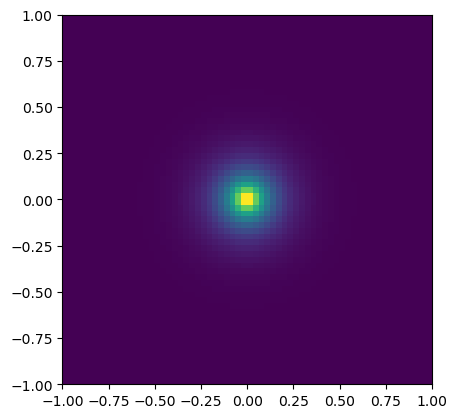

In [115]:
N =64
xmin = -1
xmax = 1 
ymin = -1 
ymax = 1
nx = N
ny = N
dx = (xmax-xmin)/(nx+2-1)
dy = (ymax-ymin)/(ny+2-1)
x = np.linspace(xmin+dx,xmax-dx,nx)
y = np.linspace(ymin+dy,ymax-dy,ny)
xx,yy = np.meshgrid(x,y, indexing="ij")
r = np.sqrt(xx**2+yy**2)
rho = np.exp(-10*r)
plt.imshow(rho,origin="lower",extent=[-1, 1, -1 ,1])
rho = rho.flatten()


In [116]:
def generate_b(dx,rho) :
    # lapacian
    # b = np.zeros(N**2)
    # b[-N:]=1
    b = -dx**2*rho
    return b 

Part 3:

Once we have the linear problem `A x = b`, we could solve the system with `scipy.linalg.solve` 

REF: https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html#scipy.linalg.solve

In [117]:
from scipy import linalg

In [118]:
A = generate_A(N)
B = generate_b(dx, rho)
print(A)
print(B)
x = linalg.solve(A,B).reshape(N,N)
print(x)


[[ 4. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  4.]]
[-1.05526579e-09 -1.30945300e-09 -1.61899200e-09 ... -1.61899200e-09
 -1.30945300e-09 -1.05526579e-09]
[[-1.62611417e-05 -3.25217557e-05 -4.87814368e-05 ... -4.87814368e-05
  -3.25217557e-05 -1.62611417e-05]
 [-3.25217557e-05 -6.50431350e-05 -9.75636990e-05 ... -9.75636990e-05
  -6.50431350e-05 -3.25217557e-05]
 [-4.87814368e-05 -9.75636990e-05 -1.46347314e-04 ... -1.46347314e-04
  -9.75636990e-05 -4.87814368e-05]
 ...
 [-4.87814368e-05 -9.75636990e-05 -1.46347314e-04 ... -1.46347314e-04
  -9.75636990e-05 -4.87814368e-05]
 [-3.25217557e-05 -6.50431350e-05 -9.75636990e-05 ... -9.75636990e-05
  -6.50431350e-05 -3.25217557e-05]
 [-1.62611417e-05 -3.25217557e-05 -4.87814368e-05 ... -4.87814368e-05
  -3.25217557e-05 -1.62611417e-05]]


Part 4:

Once we have the solution, we should convert the solution vector to the finite difference grids `u[i,j]`.

Part 5:

Now, let's visualize the solution with `matplotlib`

In [119]:
import matplotlib.pyplot as plt

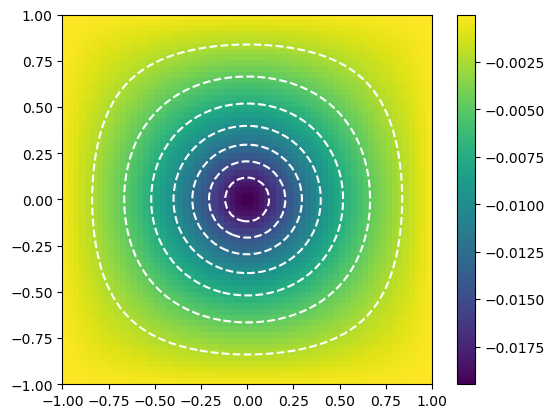

In [126]:
plt.imshow(x,origin="lower", extent=[-1, 1, -1 ,1])
plt.colorbar()
plt.contour(x,colors = "w", extent=[-1, 1, -1 ,1])


Part 6:

Now we have tested our code, we could write a "solver" function to wrap all necessary codes.\
This solver function could be either in the notebook or in a seperate python file.

Part 7:

The buttole neck of this solver is in the `linalg.solve()`.\
Let's measure the performance of `linalg.solve()` with different resolutions.

In [121]:
import time

Part 8:

Plot Computing time vs N in log-log scale.

You could see that the perofmance is propotional to `N^5`!\
This is becasue the size of the matrix A is proportional to `N^2` and\
the calculation time of `linalg.solve(M,b)` is proportial to the cubic of the size of M, N^3,\
giving `N^5` at the end.

The `scipy.linalg.solve` is robust, but since the matrix A is a sparse matrix, we could use special method to solve it.

REF: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.html

In [122]:
from scipy.sparse import csc_matrix
import scipy.sparse.linalg as splinalg

Let's measure the performance again with `spsolve()`

You got several oreders of speedup if you know the matrix is a sparse matrix.